`model`: https://drive.google.com/drive/folders/1zqSudSICI97fWn3xCrEHsDjTQAzEFoAN?usp=share_link

`times`: https://drive.google.com/drive/folders/1vWyhUAzjjrVNk5Jmwz7uZaoa6mnDASIE?usp=share_link

In [1]:
device = 'cuda'

In [2]:
import warnings
warnings.filterwarnings("ignore")

try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_PREFIX = '/content/drive/MyDrive/m1p'

    IN_COLAB = True
except:
    IN_COLAB = False

Mounted at /content/drive


In [3]:
if IN_COLAB:
    prefix = DRIVE_PREFIX
else:
    prefix = '.'
    
figures = f'{prefix}/figs/v2/main'
model_path = f'{prefix}/pretrained/model_23.ckpt'
times_path = f'{prefix}/time_measurements/ResNet18HomeMeasurements.csv'

In [4]:
if IN_COLAB:
    ! git clone -qq https://github.com/intsystems/2023-Problem-140.git
    import sys
    sys.path.append('2023-Problem-140/code')

In [5]:
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.fx

from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal

import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.style.use('seaborn')

from src.resnet18 import ResNet18
from src.module2graph import GraphInterperterWithGamma
from src.cifar_data import get_dataloaders

In [6]:
class GraphInterperterWithGumbelSoftmaxGamma(GraphInterperterWithGamma):
    def __init__(self, mod, gamma_shift=0.0, temperature=1.0):
        self.gamma_shift = gamma_shift
        self.temperature = temperature
        super().__init__(mod)

    def init_gammas(self):
        i = 0
        gammas = []
        self.gammas_name = {}
        self.atomic_operations = []
        for node in self.graph.nodes:
            if node.op == 'call_module':
                self.atomic_operations.append(node)
                gammas.append(np.random.randn()+self.gamma_shift)
                self.gammas_name[str(node)] = i# перевод в str тут для удобства. в реалньых методах это не нужно
                i+=1                        # да и вообще, тут по идее должен быть тензор/параметр
        self.gammas = torch.as_tensor(gammas).to(device)
        self.discrete = False 

    def sample_gammas(self, previous=False):
        if self.discrete:
            return self.gammas

        if not previous:
            d = torch.distributions.RelaxedBernoulli(logits=self.gammas, temperature=self.temperature)
            self.last_sample = d.rsample()

        return self.last_sample
        
    def make_gammas_discrete(self):
        self.gammas.data = (self.gammas.data>0) * 1.0
        self.discrete = True

    def relax_gammas(self, gammas=None):
        if gammas is not None:
            self.gammas.data = gammas.data
        self.discrete = False


model = ResNet18(num_classes=10).to(device)
model.load_state_dict(torch.load(model_path))

imodel = GraphInterperterWithGumbelSoftmaxGamma(model.eval()).to(device).eval()


def generate_gammas(gamma_shift: float=0, shape=imodel.gammas.shape):
    return torch.randn(*shape).to(device) + gamma_shift

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 118MB/s]


In [7]:
class HyperNet(nn.Module):
    def __init__(self, out_size, hidden_layer_num=1, hidden_size=128):
        """
        :param hidden_layer_num: количество скрытых слоев (может быть нулевым)
        :param hidden_size: количество нейронов на скрытом слое (актуально, если скрытые слои есть)
        :param out_size: количество параметров
        """
        nn.Module.__init__(self)

        layers = []
        in_ = 1 # исходная входная размерность
        for _ in range(hidden_layer_num):
            layers.append(nn.Linear(in_, hidden_size))
            layers.append(nn.ReLU())
            in_ = hidden_size
        layers.append(nn.Linear(in_, out_size))

        self.model = nn.Sequential(*layers)

    def forward(self, lambd):
        return self.model(lambd)


class PwHypernet(nn.Module):
    def __init__(self, n_intervals:int = 5, out_size: int = 10, *, Lambd):
        super().__init__()
        self.intervals = nn.Parameter(torch.randn(n_intervals, out_size))
        self.Lambd = Lambd
        
    def forward(self, lambd: torch.Tensor):
        assert 0 <= lambd and lambd < self.Lambd, f'lambd should be in [0, Lambd={self.Lambd})'

        idx = (lambd / self.Lambd * self.intervals.shape[0]).long().item()
        return self.intervals[idx]

In [8]:
train_dl, test_dl = get_dataloaders(classes=range(10), batch_size=64, img_size=33)

try:
    times = pd.read_csv(times_path, index_col=0)
    times = torch.tensor(times['mean'], dtype=torch.float32).to(device)
except:
    print('assuming time is uniform')
    times = torch.ones_like(imodel.gammas)

times /= times.sum()

100%|██████████| 170498071/170498071 [00:02<00:00, 76706911.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
loss_fn = torch.nn.CrossEntropyLoss()

ACC, LOSS, LAT = {'accuracy'}, {'loss'}, {'latency'}
ALL = ACC | LOSS | LAT

@torch.no_grad()
def validate(model, dataloader, device, getters: set=ALL):
    n_true, n_tot = 0, 0
    loss, latency = 0, 0

    for i, (X, y) in enumerate(dataloader):
        if X.shape[0] != 64:
            continue

        y_pred = model(X.to(device))

        n_tot += 64

        if 'accuracy' in getters:
            n_true += (y_pred.argmax(-1) == y.to(device)).sum().item()
        if 'loss' in getters:
            loss += loss_fn(y_pred, y.to(device)).item() * 64
        if 'latency' in getters:
            latency += model.sample_gammas(previous=True).dot(times).item() * 64

    return n_true / n_tot, loss / n_tot, latency / n_tot

In [10]:
base_accuracy, base_loss, _ = validate(model.to(device), test_dl, device, ACC | LOSS)
base_accuracy, base_loss

(0.6400240384615384, 1.1353148879149022)

In [11]:
imodel.gammas = torch.zeros_like(imodel.gammas).to(device)
imodel.make_gammas_discrete()

worst_accuracy, worst_loss, _ = validate(imodel, test_dl, device, ACC | LOSS)

imodel.relax_gammas()

worst_accuracy, worst_loss

(0.0999599358974359, 2.3025848865509033)

In [12]:
Lambd = 10.0
lambda_sampler = Uniform(0, Lambd)


def train_epoch(imodel, hypernet, optimizer, lambda_sampler=lambda_sampler, dl=train_dl, temperature=1):
    for i, (X, y) in enumerate(dl):
        if X.shape[0] != 64:
            continue

        lambd = lambda_sampler.sample().to(device).view(1)

        optimizer.zero_grad()

        imodel.gammas = hypernet(lambd)
        y_pred = imodel(X.to(device))
        loss = loss_fn(y_pred, y.to(device)) + lambd * imodel.sample_gammas(previous=False).dot(times)
        loss.backward()

        optimizer.step()

In [13]:
current_accuracy = worst_accuracy
curr_shift = 4.0
init_gammas = None

while current_accuracy <= 0.4:
    imodel.gammas = generate_gammas(curr_shift)
    current_accuracy, _, _ = validate(imodel, test_dl, device, ACC)

    print(current_accuracy, curr_shift)
    
    curr_shift += 0.5
curr_shift -= 0.5

init_gammas = imodel.gammas
init_gammas.sigmoid()

0.284755608974359 4.0
0.4634415064102564 4.5


tensor([0.9918, 0.9977, 0.9957, 0.9880, 0.9392, 0.9925, 0.9901, 0.9312, 0.9915,
        0.9596, 0.9898, 0.9773, 0.9847, 0.9937, 0.9835, 0.9979, 0.9953, 0.9835,
        0.9604, 0.9932, 0.9624, 0.9951, 0.9731, 0.9734, 0.9794, 0.9678, 0.9252,
        0.9846, 0.9942, 0.9969, 0.9928, 0.9924, 0.9972, 0.9886, 0.9958, 0.9389,
        0.9797, 0.9965, 0.9927, 0.9993, 0.9910, 0.9700, 0.9911, 0.9872, 0.9982,
        0.9954, 0.9501, 0.9888, 0.9958, 0.9948, 0.9943, 0.9931, 0.9869, 0.9924,
        0.9966, 0.9841, 0.9784, 0.9834, 0.9978, 0.9856], device='cuda:0')

In [14]:
n_intervals = 10

hypernet = PwHypernet(n_intervals=n_intervals, out_size=imodel.gammas.numel(), Lambd=Lambd).to(device)
optimizer = torch.optim.Adam(hypernet.parameters(), lr=2e-2)

hypernet.intervals.data = hypernet.intervals.data * 0 + init_gammas[None].data

lambd = torch.tensor(0.0).to(device)
assert torch.all(hypernet(lambd) == hypernet(lambd + 0.5))

In [15]:
EPOCHS = 20

temperature = 0.3

lambda_report = {}

for epoch in tqdm(range(EPOCHS), desc='training', total=EPOCHS):
    hypernet.train()

    train_epoch(imodel, hypernet, optimizer, temperature=temperature)
    temperature -= 0.05
    temperature = max(0.15, temperature)

    hypernet.eval()

    with torch.no_grad():
        for lambd in range(n_intervals):
            lambd *= Lambd / n_intervals
            imodel.gammas = hypernet(torch.tensor(lambd))

            acc, loss, latency = validate(imodel, test_dl, device)

            lambda_report.setdefault(f'{lambd}', {})
            lambda_report[f'{lambd}'].setdefault('acc', []).append(acc)
            lambda_report[f'{lambd}'].setdefault('latency', []).append(latency)

training: 100%|██████████| 20/20 [11:25<00:00, 34.30s/it]


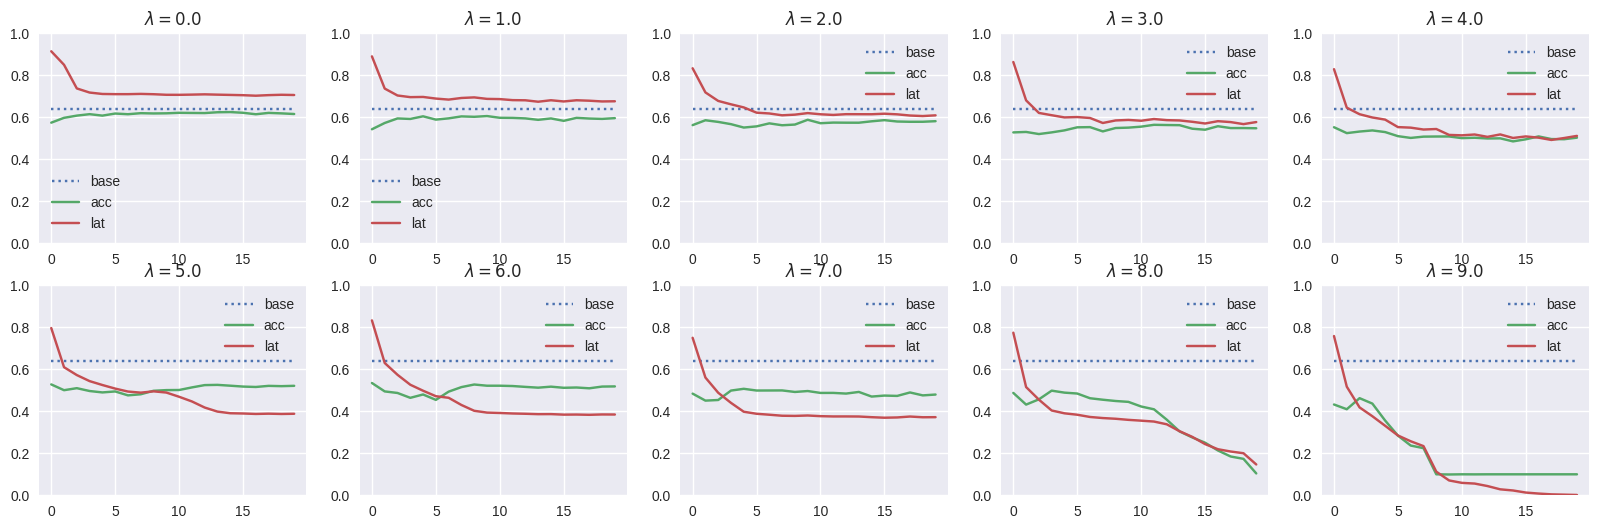

In [16]:
fig, axs = plt.subplots(2, 5, figsize=(20, 6))

for i, key in enumerate(lambda_report):
    h, w = i//5, i%5
    axs[h][w].set_title(rf"$\lambda={key}$")
    axs[h][w].plot([base_accuracy]*EPOCHS, label='base', ls=':')
    axs[h][w].plot(lambda_report[key]['acc'], label='acc')
    axs[h][w].plot(lambda_report[key]['latency'], label='lat')
    axs[h][w].legend()
    axs[h][w].set_ylim(0, 1)

plt.savefig(f'{figures}/convergence.pdf', bbox_inches='tight')

In [17]:
accuracy_vs_lambda = []
latency_vs_lambda = []

lambd_grid = [i*Lambd/n_intervals for i in range(n_intervals)]

for lambd in lambd_grid:
  imodel.gammas = hypernet(torch.tensor(lambd))
  imodel.make_gammas_discrete()
  accuracy, _, latency = validate(imodel, test_dl, device)

  latency_vs_lambda.append(latency)
  accuracy_vs_lambda.append(accuracy)

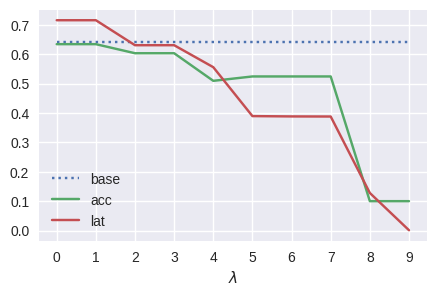

In [18]:
plt.figure(figsize=(5,3))

plt.xticks(list(range(10)))
plt.plot(lambd_grid, [base_accuracy] * len(lambd_grid), label='base', ls=':')
plt.plot(lambd_grid, accuracy_vs_lambda, label='acc')
plt.plot(lambd_grid, latency_vs_lambda, label='lat')
plt.legend()

plt.xlabel(r'$\lambda$')

plt.savefig(f'{figures}/lat&acc-lambd.pdf', bbox_inches='tight')

In [19]:
accuracy_vs_lambda, latency_vs_lambda

([0.6342147435897436,
  0.6342147435897436,
  0.6033653846153846,
  0.6033653846153846,
  0.5094150641025641,
  0.5243389423076923,
  0.5243389423076923,
  0.5243389423076923,
  0.0999599358974359,
  0.0999599358974359],
 [0.715695858001709,
  0.715695858001709,
  0.6306602954864502,
  0.6306602954864502,
  0.5558679103851318,
  0.3894219994544983,
  0.3883153200149536,
  0.3879871964454651,
  0.12784364819526672,
  0.001046848832629621])

In [20]:
print(*zip([base_accuracy - acc for acc in accuracy_vs_lambda], [1 / lat for lat in latency_vs_lambda]), sep='\n')

(0.005809294871794823, 1.3972415640242704)
(0.005809294871794823, 1.3972415640242704)
(0.036658653846153855, 1.5856396972456706)
(0.036658653846153855, 1.5856396972456706)
(0.13060897435897434, 1.7989885390346643)
(0.11568509615384615, 2.567908339541162)
(0.11568509615384615, 2.575226751191509)
(0.11568509615384615, 2.5774046390228205)
(0.5400641025641025, 7.822054627795141)
(0.5400641025641025, 955.2477576806008)
